In [1]:
# Set the matplotlib backend and make the plots a bit bigger
%matplotlib inline
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rc('text', usetex = True)

import sys

import re
from lmfit.models import GaussianModel, PolynomialModel, LorentzianModel, ExponentialModel, LinearModel
from lmfit import Parameters, fit_report, minimize, Model
from lmfit.model import save_modelresult, load_modelresult

import pandas as pd

import pyFAI
import numpy as np
import imageio
import matplotlib.pyplot as plt
sys.path.append("../../src/diamond_analysis")
sys.path.append("../../src/xrd")

from load_data import load_tiff, merge_quad23, write_SACLA_lineout, load_SACLA
from integrate_quads import integrate1d
from combine_quads import merge_four_quads
from peak_shapes import *
from fit_peaks import fit_diamond, sampleChi2, init_fits, fit_background, fit_diamond_SACLA, init_fits_SACLA, sampleChi2_SACLA, lorentzian
from plotting import plotBestFits_SACLA, plotBestFits, plot_waterfall
from directories import *
from expansion_coefficient import T_from_peak

import logging
from stipcrawl import setup_logger
logger = setup_logger.logger
quad_scale = np.loadtxt("../../.data_LW03/instprm/quad_scale_LW03.txt")

wavelength_LW03 = 1.3051 * 1e-10

#### This notebook makes use of the pyFAI package to azimuthaly integrate XRD spectra. 
Documentation of the package can be found [here](https://pyfai.readthedocs.io/en/master/index.html)

In [2]:
# define the azimuthal intyegrator objects from pyFAI
q0_ai   = pyFAI.load(poni_file_q0);
q1_ai   = pyFAI.load(poni_file_q1);
q2_ai   = pyFAI.load(poni_file_q2);
q3_ai   = pyFAI.load(poni_file_q3);

SACLA_ai = pyFAI.load(poni_file_SACLA);

# load the masks as np arrays

q0_mask     = np.array(imageio.imread(mask_q0),dtype=int);
q1_mask     = np.array(imageio.imread(mask_q1),dtype=int);
q2_mask     = np.array(imageio.imread(mask_q2),dtype=int);
q3_mask     = np.array(imageio.imread(mask_q3),dtype=int);
SACLA_mask  = np.array(imageio.imread(mask_SACLA),dtype=int);

### Lineout of SACLA PET shot
Starts at elevated pressures and releases to ambient around breakout time. 

Thermal expansion suggests a lattice constant of:
$a = 3.6 \mathring{A}$, 
which corresponds to a temperature of $T > 2000 K$.

Hugoniot state is hard to determine because of lack of VISAR but breakout is at $7.5 $ ns and DFT Hugoniot gives: $80$ GPa @ $3800$ K 

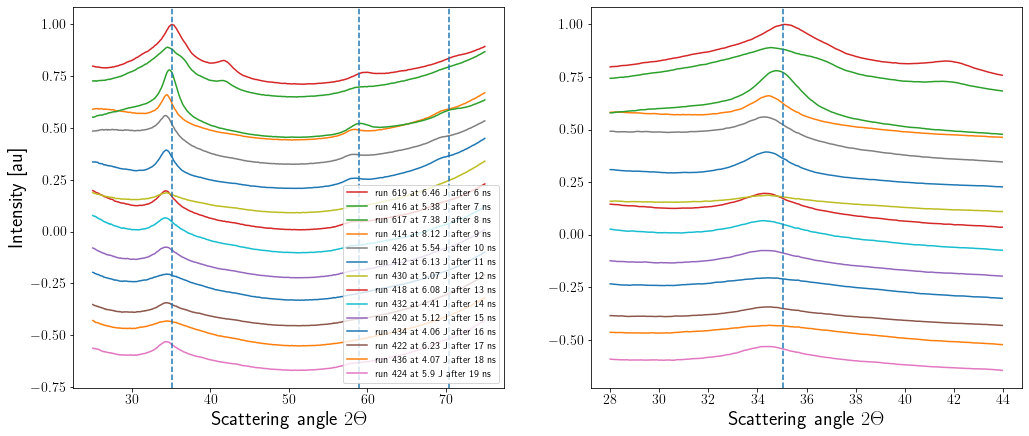

In [3]:
plot_waterfall()

In [5]:
run_filter          =   [412,414,416,418,420,422,424,426,430,432,434,436,617,619]
SACLA_shots         =   pd.read_pickle("../../.data_SACLA/logbook/PET.pkl")
PET75_shots         =   SACLA_shots[SACLA_shots['target'] == 'PET75']
PET75_shots         =   PET75_shots[PET75_shots['run'].isin(run_filter)]
runs_SACLA              = [424,436,422,434,420,432,418,430,412,426,414,617]
delays_SACLA            = np.array([PET75_shots.loc[PET75_shots['run'] == run]['delay'].values[0] for run in runs_SACLA])
SACLA_dict              = {}
for delay, run in zip(delays_SACLA,runs_SACLA):
    SACLA_dict.update({delay: run})

In [6]:
def mc_error(twotheta, twotheta_err, peak, n_samples=1000):
    mc_inputs               = np.random.normal(twotheta, twotheta_err, n_samples)
    lattice_constants       = twotheta_to_a(mc_inputs, mc_inputs, peak)[:,0]
    return lattice_constants, T_from_a(lattice_constants)

In [9]:
def lorentzian(x,amp_lor,cen_lor,wid_lor):
    return (amp_lor/np.pi * (wid_lor/((x-cen_lor)**2+wid_lor**2)))

def gauss(x, mu, sigma, C):
    return C / np.sqrt(2 * np.pi) / np.abs(sigma) * np.exp(-(x - mu)**2 / 2.0 / sigma**2)

def background(x,a,b):
        return a * x + b

bkg_model               = Model(background,prefix='bkg_')

pars                    = bkg_model.make_params()

pars['bkg_a'].set(value=np.random.normal(0.21708,0.1))
pars['bkg_b'].set(value=np.random.normal(-3.031587,1.5))

model                   = bkg_model
    
def single_peak(x, amp, C111_center, C111_sigma):
    return lorentzian(x,amp,C111_center,C111_sigma)
    #return gauss(x,C111_center,C111_sigma,amp)

peak         = Model(single_peak)
pars.update(peak.make_params())

pars['C111_center'].set(value=np.random.normal(34.0,1.), min=30, max=40)
pars['C111_sigma'].set(value=np.random.normal(2,0.1), min=0, max=100)
pars['amp'].set(value=np.random.normal(250,10),min=0.,max=10000.)


model               += peak

In [209]:
def plot_temperature_estimates():
    logger.setLevel(logging.ERROR)
    output             =   ''
    fig, ax                 =   plt.subplots(figsize=(7,7))

    Tvals                   =   np.zeros([2,12])
    Terrors                 =   np.zeros([2,12])
    for peak, thetarange, color in zip([np.array([1,1,1]),np.array([2,2,0])],[[31., 36.5],[55., 62.0]],[sns.color_palette('dark')[0],sns.color_palette('dark')[1]]):
        str_peak    = ''
        for ikl in peak:
            str_peak += str(ikl)
        fit_pattern=f'../../.data_SACLA/fits/C{str_peak}_peak_rrun_modelresult.sav'
        for delay_id, delay in enumerate([8,9,10,11,12,13,14,15,16,17,18,19]):
            run                         = SACLA_dict[delay]
            logger.debug(f'Run: {run}')

            fitfile                     = re.sub('run',str(run),fit_pattern)
            fit                         = load_modelresult(fitfile)

            run_data, ref_data          =   load_SACLA(run)

            thetamin, thetamax          = thetarange[0], thetarange[1]
            mask                        = np.logical_and(run_data[:,0] > thetamin, run_data[:,0] < thetamax)

            try:
                T, Tmin, Tmax               = T_from_peak(fit.values['C_center'], fit.params['C_center'].stderr,peak)
            except:
                logger.debug(f'Run {run} is above the interpolation range. Errors are probably too large. Trying with fake errors.')
                T, Tmin, Tmax               = T_from_peak(fit.values['C_center'], fit.values['C_center']*0.01 ,peak)
            logger.debug(f'T, Tmax, Tmin: {T, Tmin, Tmax}')
            if np.isnan(Tmax):
                logger.debug(f'Tmax is NaN, setting it to {2*T - Tmin}')
                Tmax                    = 2*T - Tmin
                logger.debug(f'delay: {delay}\nT: {T}\n yrerr: {np.array([[T-Tmin,Tmax-T]]).T}')

            ax.errorbar(delay, T, yerr=np.array([[T-Tmin,Tmax-T]]).T, fmt="o",c=color,markersize=5)

    ax.set_xlabel(r"Probe laser delay [ns]",fontsize=30)
    ax.set_ylabel(r"Diamond temperature [K]",fontsize=30)
    #ax.axhline(y=weighted_mean,xmin=9.,xmax=19.,c="r",linewidth=10)
    #ax.plot([9,19],[2700,2700],c='r',linestyle='dashed',label='After breakout mean T')
    ax.tick_params(axis='both', which= 'major', labelsize=25)
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    legend_elements = [ax.errorbar([], [], yerr=[0.01], fmt="o",c=sns.color_palette('dark')[0],markersize=5,label='(111) peak')]
    legend_elements = [ax.errorbar([], [], yerr=[0.01], fmt="o",c=sns.color_palette('dark')[1],markersize=5,label='(220) peak')]
    ax.legend(fontsize=20)
    sns.set(style="ticks")
    sns.set_style("whitegrid")
    fig.tight_layout()
    plt.savefig('../../../../../W_PhD_Articles/Heuser_ND_recovery/figures/TempDiamond.pdf', format='pdf', dpi=1200)

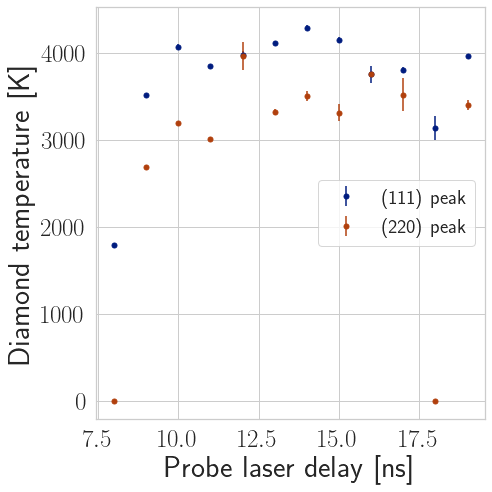

In [211]:
plot_temperature_estimates()

In [154]:
run                         = 434
fit_pattern='../../.data_SACLA/fits/C220_peak_rrun_modelresult.sav'
fitfile                     =   re.sub('run',str(run),fit_pattern)

fit                         = load_modelresult(fitfile)
fit

<Parameter 'C_center', value=58.930662676383264 +/- 0.00805, bounds=[56.0:60]>
<Parameter 'C_center', value=58.178828224826674 +/- 0.00734, bounds=[56.0:60]>
<Parameter 'C_center', value=57.991907314631206 +/- 0.00718, bounds=[56.0:60]>
<Parameter 'C_center', value=58.05967488257332 +/- 0.00935, bounds=[56.0:60]>
<Parameter 'C_center', value=57.69815707771024 +/- 0.0599, bounds=[56.0:60]>
<Parameter 'C_center', value=57.94144834489738 +/- 0.0142, bounds=[56.0:60]>
<Parameter 'C_center', value=57.87247706671323 +/- 0.0215, bounds=[56.0:60]>
<Parameter 'C_center', value=57.94461782630394 +/- 0.038, bounds=[56.0:60]>
<Parameter 'C_center', value=57.721545736940726 +/- nan, bounds=[56.0:60]>
<Parameter 'C_center', value=57.866864620257545 +/- 0.0703, bounds=[56.0:60]>
<Parameter 'C_center', value=56.00000000016587 +/- 0.0106, bounds=[56.0:60]>
<Parameter 'C_center', value=57.911019910325884 +/- 0.0228, bounds=[56.0:60]>


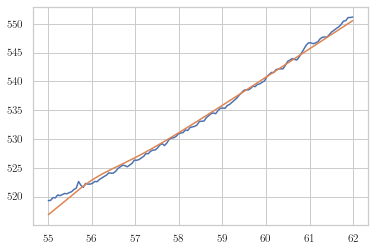

In [208]:
for delay_id, delay in enumerate([8,9,10,11,12,13,14,15,16,17,18,19]):
    run                         =   SACLA_dict[delay]
    run_data, ref_data          =   load_SACLA(run)

    thetarange                  =   [55., 62.0]

    thetamin, thetamax          = thetarange[0], thetarange[1]
    mask                        = np.logical_and(run_data[:,0] > thetamin, run_data[:,0] < thetamax)


    def background(x,a,b):
        return a * x + b

    def single_peak(x, amp, C_center, C_sigma):
        return lorentzian(x,amp,C_center,C_sigma)

    stderr       =    None
    while stderr==None:
        bkg_model                   = Model(background,prefix='bkg_')

        pars                        = bkg_model.make_params()

        pars['bkg_a'].set(value=np.random.normal(0.21708,0.1))
        pars['bkg_b'].set(value=np.random.normal(-3.031587,1.5))

        model                       = bkg_model
                    
        peak                        = Model(single_peak)
        pars.update(peak.make_params())

        pars['C_center'].set(value=np.random.normal(58.5,1.), min=56., max=60)
        pars['C_sigma'].set(value=np.random.normal(2,0.1), min=0, max=100)
        pars['amp'].set(value=np.random.normal(550,10),min=0.,max=10000.)

        model                       += peak

        out200                      = model.fit(run_data[:,1][mask], pars, x=run_data[:,0][mask],weights=1/run_data[:,2][mask])
        stderr                      = out200.params["C_center"].stderr
        if stderr != None:
            if stderr > 2.0:
                stderr=None
    print(out200.params["C_center"])
    if delay==18.:
        y,x                         =   run_data[:,1][mask], run_data[:,0][mask]
        plt.plot(x,y)
        plt.plot(x,out200.best_fit)


In [72]:
peak        =   np.array([1,1,1])
str_peak    = ''
for ikl in peak:
    str_peak += str(ikl)
str_peak

'111'

In [75]:
(peak == np.array([1,1,1])).all()

True

In [94]:
for delay_id, delay in enumerate([8,9,10,11,12,13,14,15,16,17,18,19]):
    print(f"Delay: {delay} a:{lattice[delay_id]} =/- {lattice_err[delay_id]}")

Delay: 8 a:3.589474829818451 =/- 0.0006588676044629871
Delay: 9 a:3.6255659518613537 =/- 0.0003422018059298093
Delay: 10 a:3.6376692324685176 =/- 0.0006505501429059368
Delay: 11 a:3.6328489119158234 =/- 0.00026331942192237
Delay: 12 a:3.6356617697544427 =/- 0.0009398201217052371
Delay: 13 a:3.6386858599778047 =/- 0.00040697602931016874
Delay: 14 a:3.642485830285066 =/- 0.0005762484513178734
Delay: 15 a:3.6394275530215494 =/- 0.0006553547137757576
Delay: 16 a:3.630769359354182 =/- 0.0022016843703902556
Delay: 17 a:3.6317922336741515 =/- 0.0007189596769889839
Delay: 18 a:3.6174425864673467 =/- 0.0029016160091348553
Delay: 19 a:3.635451780888997 =/- 0.0004939973643676154


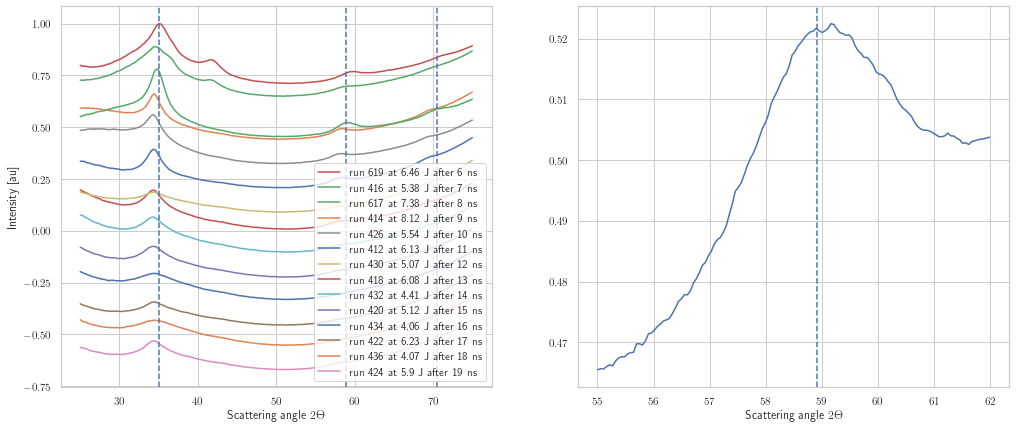

In [206]:
#PET75_runs
%matplotlib inline

run_filter          =   [412,414,416,418,420,422,424,426,430,432,434,436,617,619]

SACLA_shots         =   pd.read_pickle("../../.data_SACLA/logbook/PET.pkl")
PET75_shots         =   SACLA_shots[SACLA_shots['target'] == 'PET75']
PET75_shots         =   PET75_shots[PET75_shots['run'].isin(run_filter)]

timings             =   PET75_shots['delay'].values
timing_sort         =   np.sort(timings)

fig, ax             =   plt.subplots(1,2,figsize=(17,7))

for shot in range(len(PET75_shots)):
    run                     =   PET75_shots.iloc[shot]['run']
    E                       =   PET75_shots.iloc[shot]['E_on_sample']
    delay                   =   PET75_shots.iloc[shot]['delay']
     
    run_data, ref_data      =   load_SACLA(run)
    ### normalise Intensities
    run_data[:,1]           *=  1/max(run_data[:,1])
    ref_data[:,1]           *=  1/max(ref_data[:,1])

    offset                  =   int(np.where(timing_sort == delay)[0][0]) * 0.11

    ax[0].plot(run_data[:,0],run_data[:,1]-offset,label=f"run {run} at {E} J after {delay} ns")
    mask                    = np.logical_and(run_data[:,0] > 55.,run_data[:,0] < 62.)
    if delay==8.:
        ax[1].plot(run_data[mask][:,0],run_data[mask][:,1]-offset,label=f"run {run} at {E} J after {delay} ns")

ax[0].axvline(x=35.0540, label='Diamond 111',linestyle='dashed')
ax[0].axvline(x=58.9159, label='Diamond 220',linestyle='dashed')
ax[0].axvline(x=70.4332, label='Diamond 311',linestyle='dashed')

ax[1].axvline(x=58.9159, label='Diamond 111',linestyle='dashed')

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend([handles[idx] for idx in np.argsort(timings)],[labels[idx] for idx in np.argsort(timings)],loc='lower right')
ax[0].set_xlabel(r"Scattering angle $2\Theta$")
ax[0].set_ylabel(r"Intensity [au]")
ax[1].set_xlabel(r"Scattering angle $2\Theta$")

plt.savefig('../../.data_SACLA/figures/SACLA_waterfall.pdf')

In [17]:
#init_fits_SACLA([414,426,412,430,418,432,420,434,422,436,424], modeltype="combined", include_PET=False)
#init_fits_SACLA([436], modeltype="combined", include_PET=False)


#sampleChi2_SACLA([436],rounds=20,C111_max=100.,modeltype="combined",include_PET=False,resample=False)
#sampleChi2_SACLA([426],rounds=20,C111_max=100.,modeltype="combined",include_PET=False,resample=False)

#plotBestFits_SACLA([424,617], SACLA_shots)


Fitting run 436.
Fitting run 436.
Fitting run 436.
Fit 2 failed
Fitting run 436.
Fitting run 436.
Fitting run 436.
Fitting run 436.
Fitting run 436.
Fitting run 436.
Fitting run 436.
Fitting run 436.
Fit 10 failed
Fitting run 436.
Fitting run 436.
Fit 12 failed
Fitting run 436.
Fitting run 436.
Fit 14 failed
Fitting run 436.
Fit 15 failed
Fitting run 436.
Fit 16 failed
Fitting run 436.
Fitting run 436.
Fitting run 436.


In [254]:
def background(x,a,b,c,d):
    return a * (x-d)**2 + b*(x-d) + c

def liquid_peak(x,amp,sigma,mu):
    return amp / (np.sqrt(2*np.pi * sigma) ) * np.exp( - 1 *  (x - mu)**2 / (2 * sigma**2))

bkg_model               = Model(background,prefix='bkg_')
liquid_model            = Model(liquid_peak,prefix='liquid_')

pars                    = bkg_model.make_params()
pars.update(liquid_model.make_params())
pars['bkg_a'].set(0.21708)
pars['bkg_b'].set(-3.031587)
pars['bkg_c'].set(500,150)
pars['bkg_d'].set(39.,5.0)

pars['liquid_amp'].set(400)
pars['liquid_sigma'].set(7.)
pars['liquid_mu'].set(38.)

model                   = bkg_model + liquid_model

def triple_peak(x, amp, C111_center, C111_sigma, C220_center, C220_sigma, C311_center, C311_sigma, scale220, scale311):
    return amp * ( lorentzian(x,C111_center,C111_sigma) + \
        scale220 * 0.46 * lorentzian(x,C220_center,C220_sigma) + \
        scale311 * 0.081 * lorentzian(x,C311_center,C311_sigma) )

triple_peak         = Model(triple_peak)
pars.update(triple_peak.make_params())

pars['C111_center'].set(value=np.random.normal(34.27,1.), min=33, max=35)
pars['C220_center'].set(value=np.random.normal(58.,1), min=57, max=59)
pars['C311_center'].set(value=np.random.normal(69.32,1.5), min=68, max=70)
pars['C111_sigma'].set(value=np.random.normal(1.5,0.1), min=0, max=100)
pars['C220_sigma'].set(value=np.random.normal(2,0.1), min=0, max=5)
pars['C311_sigma'].set(value=np.random.normal(4,0.25), min=0.5, max=5)
pars['amp'].set(value=np.random.normal(300,10),min=0.,max=10000.)
pars['scale220'].set(value=np.random.normal(0.8,0.05), min=0.7, max=1.3)
pars['scale311'].set(1.2, min=0.3, max=1.3)

model               += triple_peak

In [19]:
run                     =   414
fit                     =   load_modelresult(f'../../.data_SACLA/fits/C111_peak_r412_modelresult.sav')
fit.params['C311_center'].value

AttributeError: Can't get attribute 'background' on <module 'peak_shapes' from '/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Git/PhD_Git/PhD_Thesis/notebooks/diamond_formation_LW03/../../src/xrd/peak_shapes.py'>

In [256]:
from crystalite_size import crystalite_size
wavelength_LW03         = 1.3051 * 1e-10

runs_LW03               = [182,186,188,190,192]
fits_LW03               = [load_modelresult( f'../../.data_LW03/fits/r{run}__modelresult.sav') for run in runs_LW03]

sizes_LW03              = [crystalite_size(fit,wavelength=wavelength_LW03, K=0.94) for fit in fits_LW03]
delays_LW03             = np.array([{182:9.,186:8.,188:7.,190:10.,192:11.,289:12,286:12}[run] for run in runs_LW03])
print(delays_LW03.shape)
sorting_array           = np.argsort(delays_LW03)
sizes_LW03              = np.array([sizes_LW03[i] for i in sorting_array])
delays_LW03             = np.array([delays_LW03[i] for i in sorting_array])

wavelength_SACLA        = 1.240343 * 1e-10

runs_SACLA              = [424,436,422,434,420,432,418,430,412,426,414,617]
fits_SACLA              = [load_modelresult( f'../../.data_SACLA/fits/r{run}__modelresult.sav') for run in runs_SACLA]

sizes_SACLA             = np.array([crystalite_size(fit, wavelength=wavelength_SACLA, K=0.94) for fit in fits_SACLA])
delays_SACLA            = np.array([PET75_shots.loc[PET75_shots['run'] == run]['delay'].values[0] for run in runs_SACLA])

Thetas are: 19.081195581330363 and 32.69850024922516
Crystallite size of is: 2.78 and 3.30 
Thetas are: 19.02336765401256 and 32.58270396790893
Crystallite size of is: 2.54 and 2.82 
Thetas are: 19.026570438246424 and 32.612413513657195
Crystallite size of is: 1.92 and 3.41 
Thetas are: 18.94761045458264 and 32.630709975546466
Crystallite size of is: 2.53 and 1.98 
Thetas are: 18.55912562576782 and 31.69199979534493
Crystallite size of is: 3.63 and 3.93 
(5,)
Thetas are: 17.379565846293268 and 29.085044522525564 and 34.000000000011426
Crystallite size of is: 1.63 and 0.82 and 0.08 
Thetas are: 17.556153232084192 and 29.446135812068228 and 34.00000146440687
Crystallite size of is: 0.86 and 0.50 and 0.10 
Thetas are: 17.46528364216456 and 28.943516304859166 and 34.0003267487272
Crystallite size of is: 1.22 and 0.70 and 0.08 
Thetas are: 17.51461677485636 and 29.595145249358545 and 34.00000169376098
Crystallite size of is: 0.99 and 0.57 and 0.10 
Thetas are: 17.371521750472642 and 29.1200

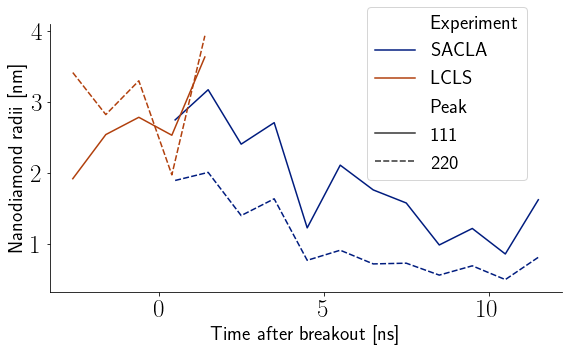

In [272]:
fig, ax             = plt.subplots(figsize=(8,5))

import seaborn as sns

data = {"Time after breakout [ns]": np.concatenate((delays_SACLA -7.5, delays_SACLA -7.5, delays_LW03 - 9.6, delays_LW03 - 9.6)),
        "Nanodiamond radii [nm]": np.concatenate((sizes_SACLA[:,0], sizes_SACLA[:,1], sizes_LW03[:,0], sizes_LW03[:,1]))*1e9,
        'Experiment': ['SACLA']*len(sizes_SACLA[:,0]) + ['SACLA']*len(sizes_SACLA[:,1]) + ['LCLS']*len(sizes_LW03[:,0]) + ['LCLS']*len(sizes_LW03[:,1]),
        'Peak': ['111']*len(sizes_SACLA[:,0]) + ['220']*len(sizes_SACLA[:,1]) + ['111']*len(sizes_LW03[:,0]) + ['220']*len(sizes_LW03[:,1])}


#ax.plot(delays_SACLA - 7.5,sizes_SACLA[:,0],label='SACLA (111)')
#ax.plot(delays_SACLA - 7.5,sizes_SACLA[:,1],label='SACLA (220)')
#ax.plot(delays_LW03 - 9.6,sizes_LW03[:,0],label='LW03 (111)')
#ax.plot(delays_LW03 - 9.6,sizes_LW03[:,1],label='LW03 (220)')

#ax.set_xlabel("Time after breakout")
#ax.set_ylabel("Crystallite size")

# plot the data
p = sns.lineplot(data=data, x="Time after breakout [ns]", y="Nanodiamond radii [nm]", hue='Experiment', style='Peak')

ax.tick_params(axis='both', which='major', labelsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=20)
# move the legend
p.legend(bbox_to_anchor=(.6, 1.1), loc='upper left',fontsize=20)
plt.tight_layout()
plt.savefig((f'../../../../../W_PhD_Conferences/DocSeminar/crystallite_sizes_SACLA_LCLS.svg'),dpi=1200)
plt.savefig((f'../../.data_SACLA/figures/crystallite_sizes_SACLA_LCLS.svg'),dpi=1200)

In [10]:
neus_r182           = np.loadtxt("../../.data_LW03/VISAR/Visar_v2_r182.txt")
time_r182           = neus_r182[:,0]
v2_r182             = neus_r182[:,1]
import pandas as pd
df  = pd.read_csv('../../.data_LW03/cif/diamond.txt')

In [11]:
def waterfallPlot(runs=[182,186,188,190,192,298],fig = None, axes = None):
    if fig == None:
        fig, axes           = plt.subplots(figsize=(8, 7))
    probingTime         = {182:9.,186:8.,188:7.,190:10.,192:11.,298:13.}
    fits                = [[]] * len(runs)
    colors              = ['gold','deepskyblue','deeppink','darkgreen','darkred','k']
    df                  = pd.read_csv('../../.data_LW03/cif/diamond.txt')
    peak_positions, scaled_int  = df['2theta'],df['F']
    axes.axvline(x = peak_positions[0], color = 'k',linestyle='dashed',linewidth=0.9)
    axes.axvline(x = peak_positions[1], color = 'k',linestyle='dashed',linewidth=0.9)
    #labels = ['7ns','8ns','9ns','10ns','11ns']
    for run_id, run in enumerate(runs):
        fits[run_id]        = load_modelresult( f'../../.data_LW03/fits/r{run}__modelresult.sav')
        
        shift               = 0
        if run==289:
            shift=-5
        t                   = int(probingTime[run])
        t_id                = (int(t-np.min(list(probingTime.values()))))
        if run==298:
            t_id            = len(runs) - 1
        data                = np.loadtxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy").T
        comps               = fits[run_id].eval_components(x=data[0])
        
        axes.plot(data[0], data[1]/np.max(data[1]) - t_id - shift,color=colors[t_id], label=f'{t} ns')
        #axes.plot(data[0], comps['C111_']/np.max(data[1]) - t_id, '--', label='Peak 111',c='r')
        #axes.plot(data[0], comps['C220_']/np.max(data[1]) - t_id, '--', label='Peak 220',c='b')
        axes.plot(data[0], comps['bkg_']/np.max(data[1]) - t_id, '--',c='r',linewidth=0.9)
        #axes.plot(data[0], comps['PET_']/np.max(data[1]) - t_id, '--', label='PET peak',c='grey')
        ypos    = (data[1]/np.max(data[1]) - t_id)[-1] + 0.2
        xpos    = 70.
        axes.text(xpos, ypos, f'{t} ns', horizontalalignment='center',verticalalignment='center',fontsize=22,color=colors[t_id])
        
    axes.tick_params(left=False, labelleft=False)
    axes.set_ylabel(r'$I$ [\textit{a.u.}]',fontsize=22)
    axes.set_xlabel(r'Scattering angle $2\theta$ [\textit{deg}]',fontsize=22)
    #axes.spines['bottom'].set_color('white')
    axes.spines['top'].set_color('white') 
    axes.spines['right'].set_color('white')
    #axes.spines['left'].set_color('white')
    axes.xaxis.set_tick_params(labelsize=25)
    axes.yaxis.set_tick_params(labelsize=25)
    axes.text(peak_positions[0]+0.5, 1.2, f'(111) Peak', horizontalalignment='left',verticalalignment='center',fontsize=20,color='k')
    axes.text(peak_positions[1]+0.5, 1.2, f'(220) Peak', horizontalalignment='left',verticalalignment='center',fontsize=20,color='k')
    axes.text(27.55-0.2, 1.2, f'Cold\nPET Peak', horizontalalignment='right',verticalalignment='center',fontsize=20,color='k')
    #plt.savefig('../../.data_LW03/figures/waterfall.pdf')
    #matplotlib.rcParams['figure.figsize'] = [8, 6]
    matplotlib.rc('text', usetex = True)
    axes.axvline(x = 27.55,ymin=0.62, color = 'k',linestyle='dashed',linewidth=0.9)

    #import tikzplotlib
    #tikzplotlib.save('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Articles/Heuser_ND_recovery/figures/waterfall.tex')
    #tikzplotlib.get_tikz_code(figure='gcf',filepath="waterfall.tex",override_externals=True)#,strict=True,wrap=False)
    #matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    #plt.savefig('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Articles/Heuser_ND_recovery/figures/waterfall.pdf')
    plt.show()

In [12]:
visar_path = "/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Git/PhD_Git/PhD_Thesis/.data_LW03/VISAR/"

In [13]:
def load_visar(run : int, visar_path : str, sweep : float) -> [np.array, np.array, np.array, np.array, np.array]:
    """
    :param run:         number of the run to load the VISAR data for
    :param visar_path:  path of the location of VISAR raw image and txt data
    :param sweep:       sweep time of the streak camera
    :return:            V1 the image arrays of the VISAR images
    :return:            lineout, time, velocity, vel_err
    """
    file_name_raw = "r" + str(run) + "_V1.tif"
    file_name_txt = "Visar_v1_r" + str(run) + ".txt"
    logger.debug(f"Trying to load raw data at: \nV1: {visar_path + file_name_raw}")
    try:
        V = plt.imread(visar_path + file_name_raw)
        logger.info(f"Loading raw data successful")
    except:
        logger.error(f"Apparently no VISAR raw data in {visar_path + file_name_raw}")
        return None, None
    try:
        data = np.loadtxt(visar_path + file_name_txt)
        logger.info(f"Loading Neutrino data successful")
    except:
        logger.error(f"Apparently no Neutrino data in {visar_path}")
        return None, None
    ### Do the vertical lineouts
    lineout = np.sum(V,axis=1)

    ### set the time and v/v_err data
    time = data[:,0]
    velocity = data[:,1]
    vel_err = data[:,2]
    return V, lineout, time, velocity, vel_err

[~]  Loading raw data successful
INFO:stipcrawl.setup_logger:Loading raw data successful
[~]  Loading Neutrino data successful
INFO:stipcrawl.setup_logger:Loading Neutrino data successful


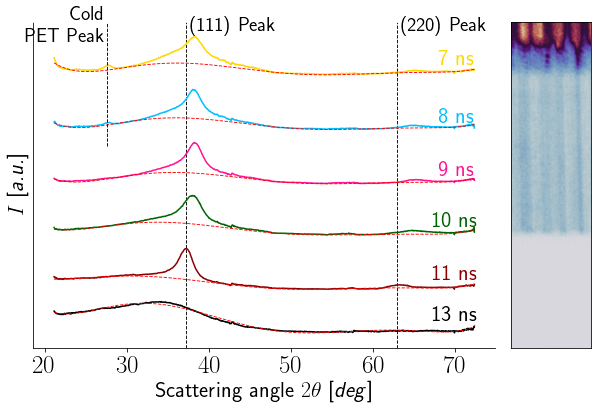

In [14]:
logger.setLevel(logging.INFO)
V182, LO, t_r182, v_r18, v_err_r1822  = load_visar(182,visar_path,20.)
ROI                         = V182[:,550:800]

#time = np.linspace(0,20.,len(LO_1))
fig                         = plt.figure(figsize=(10,6))
gs                          = fig.add_gridspec(1, 6)

ax0                         = fig.add_subplot(gs[0:1, 0:5])
ax1                         = fig.add_subplot(gs[0:1, 5:6])
ax1.imshow(ROI,cmap="twilight")
ax1.set_xticks([])
ax1.set_yticks([])
waterfallPlot(fig=fig, axes=ax0)
#axarr[0,1].imshow(V190_2)
#axarr[1,0].plot(time, LO_1)
#axarr[1,1].plot(time, LO_2)
#plt.show()

In [15]:
r182 =          np.loadtxt(f"../../.data_LW03/lineouts/r{182}_Q23.xy").T
print(f"Total angular coverage goes from {r182[0,0]} to {r182[0,-1]}")
atoms_per_uc        = 8.
u                   = 1.66053904e-27
mass_per_atom       = 12*u*1000
mass_per_uc_gramm   = atoms_per_uc * mass_per_atom
n                   = 1

runs=[182,186,188,190,192]
probingTime     = {182:9.,186:8.,188:7.,190:10.,192:11.}

for run_id, run in enumerate(runs):
    fit         = load_modelresult( f'../../.data_LW03/fits/r{run}__modelresult.sav')
    print(fit.best_values["C111_center"])
    theta               = fit.best_values["C111_center"]
    d                   = n * (wavelength * 10)/ (2*np.sin(np.deg2rad(theta)/2.))
    a_cm                = d * np.sqrt(3)
    vol_gcc             = a_cm**3
    rho                 = mass_per_uc_gramm / vol_gcc
    tmp                 = fit.params["C111_center"].stderr
    print(f"Run is: {run}, stderr is: {tmp}")
    #rho_err             = np.sqrt((mass_per_uc_gramm)/((np.sqrt(3)*wavelength*10)**3)\
    #                    *8*3*(np.sin(np.deg2rad(theta)/2.))**2*np.cos(np.deg2rad(theta)/2.)\
    #                    * (fit.params["C111_center"].stderr)**2)
    
    #print(f"Density at time delay {probingTime[run]} is {rho} +/- {rho_err}")

#rho_C=8*M_C/UC_volume_C

Total angular coverage goes from 21.125430507995922 to 72.32085688075271
38.162391162660725
Run is: 182, stderr is: 0.005885989636832418
38.04673530802512
Run is: 186, stderr is: 0.007076381117043412
38.05314087649285
Run is: 188, stderr is: 0.010658776669114817
37.89522090916528
Run is: 190, stderr is: 0.00587794810830576
37.11825125153564
Run is: 192, stderr is: 0.005217057640529357


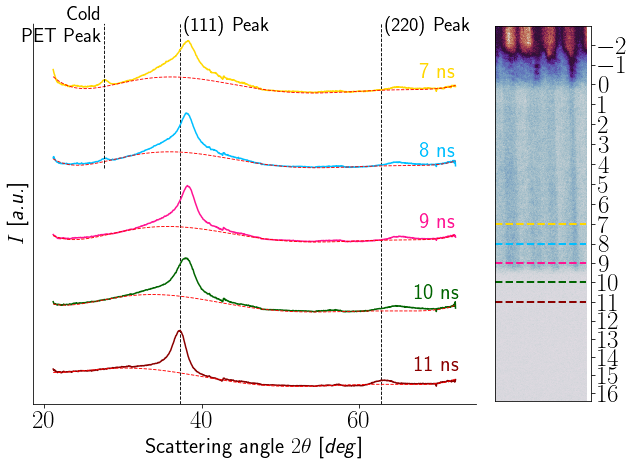

In [16]:
from scipy.interpolate import interp1d
matplotlib.rc('font', weight='bold')

fig                         = plt.figure(figsize=(10,7))
gs                          = fig.add_gridspec(1, 5)

ax0                         = fig.add_subplot(gs[0:1, 0:4])
ax1                         = fig.add_subplot(gs[0:1, 4:5])
ax1.imshow((ROI),cmap="twilight",interpolation='nearest')
ax1.set_xticks([])
#line                        = matplotlib.lines.Line2D([0,1],[0,1],marker=">")

ticksPos                       = np.arange(len(t_r182))
### interpolate to map y values postions to the corresponding tick position
labelMapper                    = interp1d(t_r182, ticksPos)

### get the positions of where we have integer values for the y value
tMin, tMax                     = int(t_r182.min()), int(t_r182.max())
tickLables                     = np.arange(tMin,tMax+1)

#polynomial                     = np.poly1d([-2.,1.52475e-02,9.14541e-06,-5.96076e-09])

tickPositions = [labelMapper(y_value) for y_value in tickLables] 
ax1.set_yticks(tickPositions)
ax1.set_yticklabels([f"${label}$" for label in tickLables],ha='left')
ax1.yaxis.tick_right()
colors = ['gold','deepskyblue','deeppink','darkgreen','darkred','k']

for id, time in enumerate([7,8,9,10,11]):
        ax1.hlines(y=labelMapper(time), xmin=0, xmax=250, linewidth=2, color=colors[id],linestyle='--')

ax1.yaxis.set_tick_params(labelsize=25)
matplotlib.rc('text', usetex = True)
waterfallPlot(fig=fig,axes=ax0,runs=[182,186,188,190,192])
ax0.set_yticks([])
fig.tight_layout()
fig.savefig('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Articles/Heuser_ND_recovery/figures/waterfall.pdf')

fig.savefig('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Articles/Heuser_ND_recovery/figures/waterfall.eps')

In [17]:
df                  = pd.read_csv('../../.data_LW03/cif/diamond.txt')
print(f'Theoretical intensity is: {df.iloc[0]["I"]/df.iloc[1]["I"]}')
for run_id, run in enumerate([182,186,188,190,192]):
    fit         = load_modelresult( f'../../.data_LW03/fits/r{run}__modelresult.sav')
    print(f'Amplitute C111 is: {fit.best_values["C111_amplitude"]}\nAmplitute C220 is: {fit.best_values["C220_amplitude"]}\nRatio is: {fit.best_values["C111_amplitude"]/fit.best_values["C220_amplitude"]}')

Theoretical intensity is: 3.4715194806051413
Amplitute C111 is: 1669.6287181535613
Amplitute C220 is: 142.75218042759838
Ratio is: 11.695994507070736
Amplitute C111 is: 1579.134956886243
Amplitute C220 is: 146.94416502419804
Ratio is: 10.746496511965608
Amplitute C111 is: 1352.727637491231
Amplitute C220 is: 65.27615683177999
Ratio is: 20.723150735992007
Amplitute C111 is: 1478.2856140117237
Amplitute C220 is: 270.6475499240235
Ratio is: 5.462032131555263
Amplitute C111 is: 1049.417240529108
Amplitute C220 is: 107.40425339499315
Ratio is: 9.770723294074205


In [18]:
df                  = pd.read_csv('../../.data_LW03/cif/diamond.txt')
df

,h,k,l,d(angstrom),F(real),F(imag),F,2theta,I,M,ID(lambda),Phase
0,1,1,1,2.043820,10.807323,-10.762347,15.25210,37.23873,100.00000,8,1,1
1,2,2,0,1.251579,12.043767,0.038663,12.04380,62.84992,28.80583,12,1,1
2,3,1,1,1.067350,5.089139,5.125703,7.22303,75.37782,14.30697,24,1,1
3,4,2,2,0.722599,4.771778,0.020717,4.77182,129.12626,6.93078,24,1,1
4,3,3,1,0.812132,2.450871,-2.430824,3.45191,106.93180,2.56460,24,1,1
5,4,0,0,0.885000,6.833784,0.026978,6.83384,95.01142,2.44259,6,1,1
6,2,2,2,1.021910,-0.005629,1.533497,1.53351,79.36893,0.19697,8,1,1


In [19]:
df.iloc[0]["I"]/df.iloc[1]['I']

3.4715194806051413

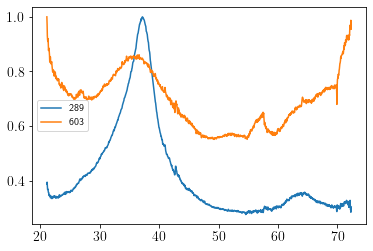

In [20]:
r286_Q23 = np.loadtxt("../../.data_LW03/lineouts/r286_Q23.xy").T
r289_Q23 = np.loadtxt("../../.data_LW03/lineouts/r289_Q23.xy").T
r298_Q23 = np.loadtxt("../../.data_LW03/lineouts/r298_Q23.xy").T
r591_Q23 = np.loadtxt("../../.data_LW03/lineouts/r591_Q23.xy").T
r192_Q23 = np.loadtxt("../../.data_LW03/lineouts/r192_Q23.xy").T

#plt.plot(r286_Q23[0], r286_Q23[1]/np.max(r286_Q23[1]),label='286')
plt.plot(r289_Q23[0], r289_Q23[1]/np.max(r289_Q23[1]),label='289')
run         = 603
file        = "../../.data_LW03/lineouts/r" + str(run) + "_Q23.xy"
r_data      = np.loadtxt(file).T
plt.plot(r_data[0], r_data[1]/np.max(r_data[1]), label=str(run))

plt.legend()

In [21]:
r289_Q23

array([[ 21.12543051,  21.16581239,  21.20619427, ...,  72.2573423 ,
         72.28909959,  72.32085688],
       [393.64314078, 399.75075106, 385.78433452, ..., 288.19235301,
        302.648797  , 307.56663388]])

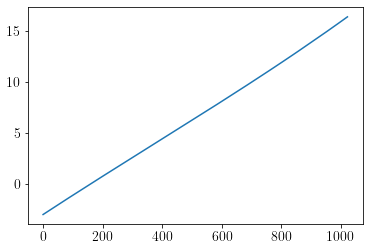

In [22]:
plt.plot(ticksPos,t_r182)

In [23]:
runs                = [182,186,188,190,192,289]
d_111_ambient       = 2.04382 
d_220_ambient       = 1.25158
peak_ratios         = np.zeros(len(runs))
d_C111              = np.zeros(len(runs))
d_C220              = np.zeros(len(runs))
strain_111          = np.zeros(len(runs))
strain_220          = np.zeros(len(runs))

for run_id, run in enumerate(runs):
    result = load_modelresult(f'../../.data_LW03/fits/r{run}__modelresult.sav')
    param_dict              = result.params.valuesdict()
    peak_ratios[run_id]     = param_dict['C220_amplitude'] / param_dict['C111_amplitude']

    d_C111[run_id]          = wavelength / (2. * np.sin( np.deg2rad(param_dict['C111_center'] / 2.)))
    d_C220[run_id]          = wavelength / (2. * np.sin( np.deg2rad(param_dict['C220_center'] / 2.)))

    strain_111[run_id]      = np.abs(d_111_ambient - d_C111[run_id] * 1e9) / d_111_ambient
    strain_220[run_id]      = np.abs(d_220_ambient - d_C220[run_id] * 1e9) / d_220_ambient

    #data            = np.loadtxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy").T
    #fits[run_id]    = fit_diamond(data)
    #save_modelresult(fits[run_id], f'../../.data_LW03/fits/r{run}__modelresult.sav')

In [24]:
d_C111 *1e9

array([0.19961289, 0.20019711, 0.20016466, 0.20096798, 0.20502188,
       0.20512471])

In [25]:
d_C220 * 1e9

array([0.12079376, 0.1211755 , 0.12107728, 0.12101689, 0.12421176,
       0.12264931])

In [26]:
plt.scatter(probing_times, strain_111, label='Strain 111 peak')
plt.scatter(probing_times, strain_220, label='Strain 220 peak')
plt.legend()

NameError: name 'probing_times' is not defined

In [ ]:
peak_positions, scaled_int  = peaks_from_file('../../.data_LW03/cif/diamond.txt')
theoretical_int             = scaled_int[1] / scaled_int[0]
print(theoretical_int)

In [ ]:
peak_positions

In [ ]:
plt.plot(r182_Q23[0],r182_Q23[1])
out, param_dict = fit_double_peak(r182_Q23)
print(fit_report(out))
plt.plot(r182_Q23[0],lin_gauss_2lorentzian(r182_Q23[0],*list(param_dict.values())))

In [ ]:
param_dict['scale']

In [ ]:
list(param_dict.values())